In [14]:
7import pathlib
from glob import glob
import fnmatch
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [15]:
data_dir_path = "PlantVillage"
data_dir_train = pathlib.Path(data_dir_path)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

20636


In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [18]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_path,
    shuffle=True,
    seed=123,
    validation_split=0.70,
    subset="training",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 20638 files belonging to 15 classes.
Using 6192 files for training.


In [19]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [20]:
temp_class = []
temp_dict = {}
for images, labels in dataset:
    for i, val in enumerate(class_names):
        if class_names[labels[i]] not in temp_class:
          temp_class.append(class_names[labels[i]])
          temp_dict[class_names[labels[i]]] = images[i].numpy().astype("uint8")
    if len(temp_class) == len(class_names):
        break

In [21]:
plt.figure(figsize=(15, 15))
for i in range(len(class_names)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(temp_dict[class_names[i]])
    plt.title(class_names[i])
    plt.axis("off")

NameError: name 'plt' is not defined

In [22]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [23]:
train_ds, test_ds, val_ds = get_dataset_partition_tf(dataset)

In [24]:
print("Training size:", len(train_ds)*BATCH_SIZE)
print("Testing size:", len(test_ds)*BATCH_SIZE)
print("Validation size:", len(val_ds)*BATCH_SIZE)

Training size: 4960
Testing size: 640
Validation size: 608


In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
#Data Normalization
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
#data augmentation
data_augmentation = keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

NameError: name 'plt' is not defined

In [29]:
# input shape of (img_height, img_width, 3)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [30]:

model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape)

In [31]:
EPOCHS

30

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [34]:
%%time
EPOCHS = EPOCHS
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/30
155/155 [==============================] - 143s 713ms/step - loss: 2.4326 - accuracy: 0.1942 - val_loss: 2.4384 - val_accuracy: 0.2145
Epoch 2/30
155/155 [==============================] - 95s 614ms/step - loss: 1.9753 - accuracy: 0.3493 - val_loss: 2.0505 - val_accuracy: 0.3716
Epoch 3/30
155/155 [==============================] - 77s 496ms/step - loss: 1.6165 - accuracy: 0.4559 - val_loss: 1.6699 - val_accuracy: 0.4645
Epoch 4/30
155/155 [==============================] - 97s 625ms/step - loss: 1.4263 - accuracy: 0.5283 - val_loss: 1.9155 - val_accuracy: 0.4426
Epoch 5/30
155/155 [==============================] - 104s 671ms/step - loss: 1.2400 - accuracy: 0.5714 - val_loss: 1.4987 - val_accuracy: 0.4983
Epoch 6/30
155/155 [==============================] - 91s 583ms/step - loss: 1.0778 - accuracy: 0.6313 - val_loss: 1.7877 - val_accuracy: 0.4578
Epoch 7/30
155/155 [==============================] - 123s 791ms/step - loss: 0.9505 - accuracy: 0.6707 - val_loss: 2.0701 - val

In [22]:
def visualize_train_result(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

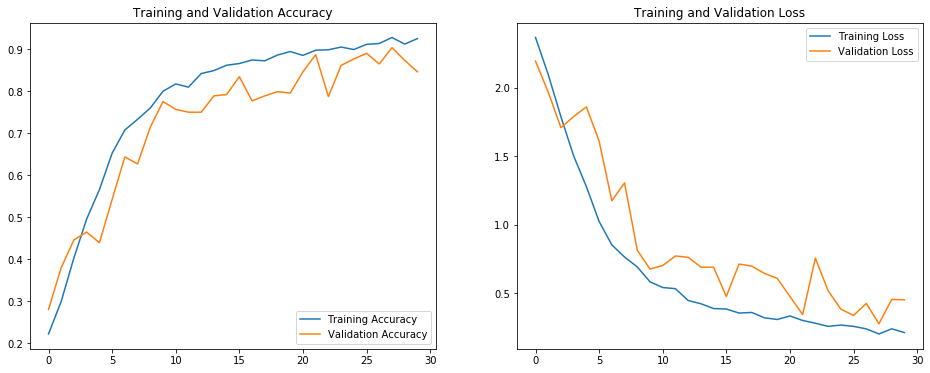

In [23]:
visualize_train_result(history, EPOCHS)

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

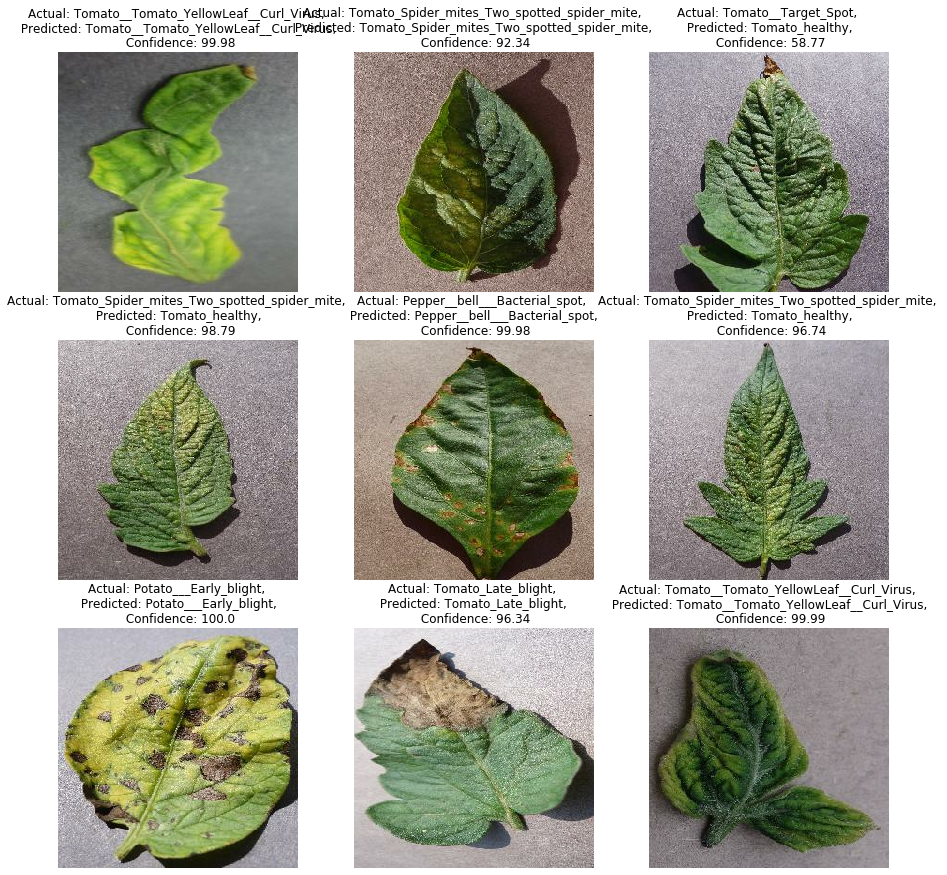

In [30]:
plt.figure(figsize=(15, 15))
tak = test_ds.take(1)
for images, labels in tak:
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)

        plt.imshow(images[i].numpy().astype("uint8"))
        image_1 = images[i].numpy()
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")        
        plt.axis("off")
del tak
